### 3. Boston & San Francisco Airbnb - Modelling

### Imports

In [1]:
import pandas as pd
import numpy as np
import decimal
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import sklearn as skl

print ('Sci-Kit Learn version',skl.__version__)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
print("TensorFlow version = ", tf.__version__)

import xgboost as xgb
print("XGBoost version = ", xgb.__version__)

Sci-Kit Learn version 0.24.1
TensorFlow version =  2.3.0
XGBoost version =  1.4.2


### Classes

In [2]:
class Reg_Score:
    """ 
    Create Dataframe to hold Model Scores
    """
    def __init__(self):
        
        self.__cols__=['Model', 'R2_Score_train', 'R2_Score_test', 'R2_Score_train_Adj','R2_Score_test_Adj', 'RMSE_train', 'RMSE_test','RMSE_diff']
        self.__scores_df__ = pd.DataFrame(columns=self.__cols__)
     
    def add(self,model,r2_score_train,r2_score_test,rmse_train,rmse_test,p_train=0,n_train=0,p_test=0,n_test=0):
        """
        Add another row to the dataframe
        model  - Model name string
        r2_score_train - R2 Score training data
        r2_score_test - R2 Score testing data
        
        """
        if(p_train>0 and n_train>0 and p_test>0 and n_test>0 ):
            r2_score_train_adjusted= self.adjusted_R2(r2_score_train, p_train, n_train)
            r2_score_test_adjusted= self.adjusted_R2(r2_score_test, p_test, n_test)
        else:
            r2_score_train_adjusted=np.NaN
            r2_score_test_adjusted=np.NaN
 
        self.__scores_df__=self.__scores_df__.append(pd.DataFrame([{'Model':model,
                                    'R2_Score_train':r2_score_train, 'R2_Score_test':r2_score_test,
                                    'R2_Score_train_Adj':r2_score_train_adjusted, 'R2_Score_test_Adj':r2_score_test_adjusted,
                                    'RMSE_train':rmse_train, 'RMSE_test':rmse_test, 'RMSE_diff':rmse_train-rmse_test}]))
    
    def get_score(self):
        """
        return DataFrame containing scores
        """
        return self.__scores_df__
    
    def write_csv(self,filename):
        """
        Write scores to csv file
        """
        self.__scores_df__.to_csv(filename)
        
    def adjusted_R2(self,R2,p,n):
        """ 
        R2 R Squared Score
        p number of features
        n number of samples 
        """
        return 1-(1-R2)*(n-1)/(n-p-1)

    

# Test Reg_Score class
my_scores = Reg_Score()

my_scores.add("model",0.8,0.7,60,45,12,3000,12,300)

my_scores.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,model,0.8,0.7,0.799197,0.687456,60,45,15


In [3]:
# Variables
target_name='price'

# Create instance to contain regression results
scores_df = Reg_Score()

### Load Data

In [4]:
# Load treated data into dataframe
bdf=pd.read_csv('bdf_long.csv',sep=';', encoding='utf8')
sfdf=pd.read_csv('sfdf_long.csv',sep=';', encoding='utf8')

In [5]:
print("bdf",bdf.shape)
print("sfdf",sfdf.shape)

bdf (3109, 128)
sfdf (6639, 162)


In [6]:
print(bdf.price.max(),bdf.price.min())
print(sfdf.price.max(),sfdf.price.min())

750.0 19.0
1575.0 10.0


In [7]:
# Check for Nulls
print("bdf",np.sum(bdf.isnull().sum()))
print("sfdf",np.sum(sfdf.isnull().sum()))

bdf 0
sfdf 0


### Separate X and y

In [8]:
# Remove target from X dataframe create y dataframe containing target using boston data
# Using Boston Data
X = bdf.drop(target_name, axis=1)
y = pd.DataFrame(bdf[target_name])
log_y = np.log(y)
log_y.columns = ['log_price']

print("X = ", X.shape)
print("y = ", y.shape)
print("log_y = ", log_y.shape)

X =  (3109, 127)
y =  (3109, 1)
log_y =  (3109, 1)


In [9]:
# Switch target to log price
target_name='log_price'

### Create training and test datasets

In [10]:
# Split X and y into train and test dataframes for analysis
X_train, X_test, y_train, y_test = train_test_split(X, log_y, test_size=0.3, random_state=45, shuffle=True)

print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [11]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (2176, 127)
X_test (933, 127)
y_train (2176, 1)
y_test (933, 1)


In [12]:
X_train.head(5)

,host_listings_count,host_total_listings_count,accommodates,bathrooms_text,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,nhd_Brighton,nhd_Downtown,rmt_Entire_home/apt,rmt_Private_room,ppt_Boat,ppt_Entire_apartment,ppt_Entire_condominium,ppt_Entire_guest_suite,ppt_Entire_house,ppt_Entire_serviced_apartment,ppt_Entire_townhouse,ppt_Private_room_in_apartment,ppt_Private_room_in_condominium,ppt_Private_room_in_house,ppt_Private_room_in_loft,ppt_Private_room_in_townhouse,ppt_Room_in_hotel,amt_washer,amt_dishwasher,amt_refrigerator,amt_patio_or_balcony,amt_iron,amt_heating,amt_extra_pillows_and_blankets,amt_microwave,amt_shampoo,amt_cable_tv,amt_hair_dryer,amt_essentials,amt_free_street_parking,amt_coffee_maker,amt_stove,amt_oven,amt_hangers,amt_cooking_basics,amt_dryer,amt_bed_linens,amt_tv_with_standard_cable,amt_kitchen,amt_fire_extinguisher,amt_luggage_dropoff_allowed,amt_lockbox,amt_bathtub,amt_pack__n_play_travel_crib,amt_paid_parking_off_premises,amt_host_greets_you,amt_indoor_fireplace,amt_elevator,amt_tv,amt_private_entrance,amt_room-darkening_shades,amt_ethernet_connection,amt_lock_on_bedroom_door,amt_bbq_grill,amt_body_soap,amt_conditioner,amt_ev_charger,amt_toaster,amt_stainless_steel_oven,amt_wine_glasses,amt_baking_sheet,amt_shower_gel,amt_children_s_books_and_toys,amt_outdoor_furniture,amt_high_chair,amt_hot_water_kettle,amt_cleaning_products,amt_central_heating,amt_crib,amt_children_s_dinnerware,amt_changing_table,amt_outdoor_dining_area,amt_baby_safety_gates,amt_baby_bath,amt_bath___body_works_shampoo,amt_bath___body_works_conditioner,amt_paid_parking_garage_on_premises,amt_washer_- in_unit,amt_window_guards,amt_bath___body_works_body_soap,amt_dryer_- in_unit,amt_gym,amt_free_dryer-in_building,amt_free_washer-in_building,amt_central_air_conditioning,amt_stainless_steel_electric_stove,amt_pool,amt_free_washer-in_unit,amt_shared_garden_or_backyard,amt_free_dryer-in_unit,amt_tv_with_chromecast,amt_private_gym_in_building,amt_pool_table,amt_ping_pong_table,amt_children_s_books_and_toys_for_ages_0-2_years_old_and_2-5_years_old,amt_shared_outdoor_pool,amt_shared_gym_in_building,amt_dedicated_workspace:_desk_and_table,amt_whirlpool_refrigerator
2028,0.005376,0.005376,0.250,0.166667,0.166667,0.111111,0.029,0.112511,0.029,0.029,5.238689e-07,5.238689e-07,0.0290,5.238689e-07,0.018033,0.024000,0.93,1.0,0.9,1.0,1.0,1.0,0.9,0.039474,0.039474,0.000000,0.0,0.035513,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,0.001344,0.001344,0.125,0.000000,0.166667,0.000000,0.029,0.112511,0.029,0.029,5.238689e-07,5.238689e-07,0.0290,5.238689e-07,0.006557,0.010667,1.00,1.0,1.0,1.0,1.0,1.0,1.0,0.019737,0.000000,0.058824,0.0,0.022954,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2725,0.000000,0.000000,0.375,0.166667,0.500000,0.166667,0.091,0.1125

### OLS Model

In [13]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_preds = regr.predict(X_test)

In [14]:
print(X_test.shape)
print(y_test.shape)

(933, 127)
(933, 1)


In [15]:
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train),np.exp(regr.predict(X_train))))
rmse_test= np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( regr.predict(X_train)))

# Get the dataset dimensions to calculate the adjusted R2
n_train=X_train.shape[0]
p_train=X_train.shape[1]
n_test=X_test.shape[0]
p_test=X_test.shape[1]

scores_df.add("OLS Model", r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727


### Tensorflow Model

In [16]:
X_train_tf=tf.constant(X_train)
y_train_tf=tf.constant(y_train)
X_test_tf=tf.constant(X_test)
y_test_tf=tf.constant(y_test)

tf.keras.backend.set_floatx('float64')
X_train.shape

(2176, 127)

In [17]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(200,activation='relu'),
                             tf.keras.layers.Dense(200,activation='relu'),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mse,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["mse"])


# Fit the model
history=model.fit(X_train_tf, y_train_tf, epochs=25, verbose=0) # train for n epochs

In [18]:
# Display summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 200)                 25600     
_________________________________________________________________
dense_1 (Dense)              (32, 200)                 40200     
_________________________________________________________________
dense_2 (Dense)              (32, 100)                 20100     
_________________________________________________________________
dense_3 (Dense)              (32, 100)                 10100     
_________________________________________________________________
dense_4 (Dense)              (32, 1)                   101       
Total params: 96,101
Trainable params: 96,101
Non-trainable params: 0
_________________________________________________________________


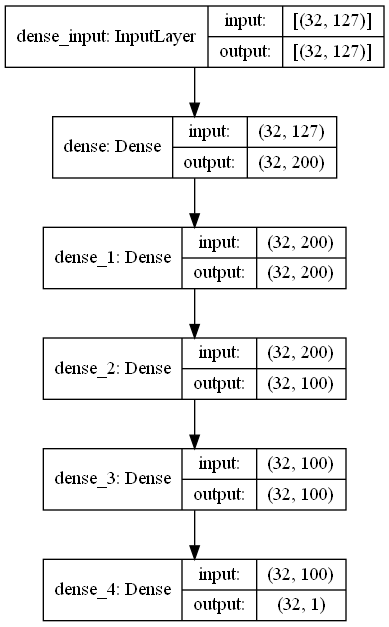

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

#### Loss Curve

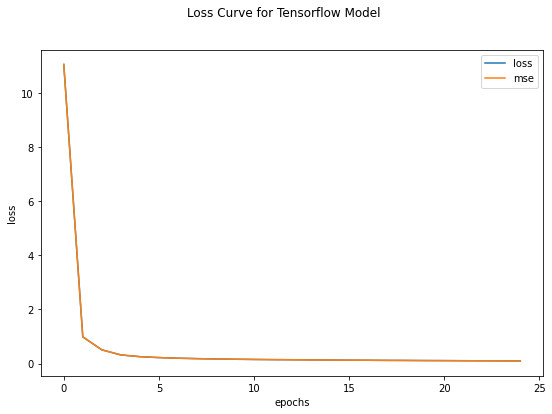

In [20]:
# Plot history (also known as a loss curve)
fig,axes=plt.subplots(1,1,figsize=(9,6))
pd.DataFrame(history.history).plot(ax=axes)
plt.suptitle("Loss Curve for Tensorflow Model")
plt.ylabel("loss")
plt.xlabel("epochs");

In [21]:
y_preds = model.predict(X_test_tf)

In [22]:
[loss_test, mse_test]=model.evaluate(X_test_tf, y_test_tf)

30/30 [==============================] - 0s 1ms/step - loss: 0.1507 - mse: 0.1507


In [23]:
epoch_count=len(history.history['loss'])

mse_train=history.history['mse'][-1]
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train_tf),np.exp(model.predict(X_train_tf))))
rmse_test= np.sqrt( mean_squared_error(np.exp(y_test_tf),np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test_tf), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train_tf), np.exp( model.predict(X_train_tf)))

scores_df.add("TF Model "+str(epoch_count),r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766


In [24]:
# Create a callback that will stop the fitting iterations when the mse stops improving
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(200,activation='relu'),
                             tf.keras.layers.Dense(200,activation='relu'),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mse,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["mse"])
# Fit the model
history=model.fit(X_train_tf, y_train_tf, epochs=100, batch_size=1,
                  callbacks=[callback],
                  verbose=0) # train for n epochs

In [25]:
epoch_count=len(history.history['loss'])
y_preds = model.predict(X_test_tf)
[loss_test, mse_test]=model.evaluate(X_test_tf, y_test_tf)

mse_train=history.history['mse'][-1]
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train_tf),np.exp(model.predict(X_train_tf))))
rmse_test= np.sqrt( mean_squared_error(np.exp(y_test_tf),np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test_tf), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train_tf), np.exp( model.predict(X_train_tf)))

scores_df.add("TF Model " + str(epoch_count),r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

30/30 [==============================] - 0s 930us/step - loss: 0.1589 - mse: 0.1589


,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373


### XGBoost Model

In [26]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 200)

In [27]:
xg_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse', early_stopping_rounds=10,  verbose=True) # Fit training data

evals_result = xg_reg.evals_result()


[0]	validation_0-rmse:3.90701	validation_1-rmse:3.87245
[1]	validation_0-rmse:3.52405	validation_1-rmse:3.49120
[2]	validation_0-rmse:3.18006	validation_1-rmse:3.14870
[3]	validation_0-rmse:2.87121	validation_1-rmse:2.84115
[4]	validation_0-rmse:2.59392	validation_1-rmse:2.56522
[5]	validation_0-rmse:2.34568	validation_1-rmse:2.31768
[6]	validation_0-rmse:2.12316	validation_1-rmse:2.09521
[7]	validation_0-rmse:1.92347	validation_1-rmse:1.89652
[8]	validation_0-rmse:1.74427	validation_1-rmse:1.71699
[9]	validation_0-rmse:1.58426	validation_1-rmse:1.55761
[10]	validation_0-rmse:1.44098	validation_1-rmse:1.41566
[11]	validation_0-rmse:1.31252	validation_1-rmse:1.28741
[12]	validation_0-rmse:1.19806	validation_1-rmse:1.17249
[13]	validation_0-rmse:1.09705	validation_1-rmse:1.07145
[14]	validation_0-rmse:1.00705	validation_1-rmse:0.98230
[15]	validation_0-rmse:0.92771	validation_1-rmse:0.90303
[16]	validation_0-rmse:0.85652	validation_1-rmse:0.83184
[17]	validation_0-rmse:0.79471	validation

[144]	validation_0-rmse:0.31981	validation_1-rmse:0.35049
[145]	validation_0-rmse:0.31961	validation_1-rmse:0.35064
[146]	validation_0-rmse:0.31953	validation_1-rmse:0.35064
[147]	validation_0-rmse:0.31938	validation_1-rmse:0.35065
[148]	validation_0-rmse:0.31938	validation_1-rmse:0.35065
[149]	validation_0-rmse:0.31938	validation_1-rmse:0.35065
[150]	validation_0-rmse:0.31917	validation_1-rmse:0.35053
[151]	validation_0-rmse:0.31900	validation_1-rmse:0.35035
[152]	validation_0-rmse:0.31900	validation_1-rmse:0.35035
[153]	validation_0-rmse:0.31900	validation_1-rmse:0.35035
[154]	validation_0-rmse:0.31900	validation_1-rmse:0.35035
[155]	validation_0-rmse:0.31900	validation_1-rmse:0.35035
[156]	validation_0-rmse:0.31900	validation_1-rmse:0.35035
[157]	validation_0-rmse:0.31900	validation_1-rmse:0.35035
[158]	validation_0-rmse:0.31866	validation_1-rmse:0.35024
[159]	validation_0-rmse:0.31852	validation_1-rmse:0.35021
[160]	validation_0-rmse:0.31852	validation_1-rmse:0.35021
[161]	validati

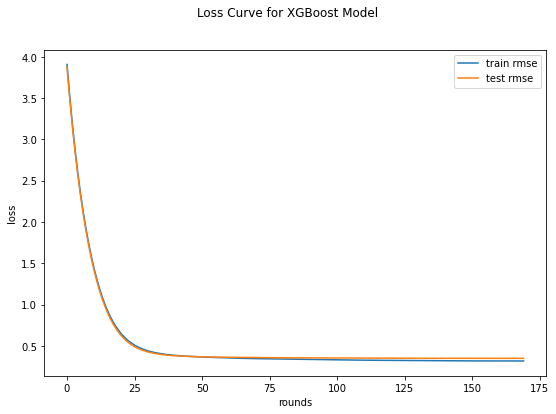

In [28]:
# Plot history (also known as a loss curve)
fig,axes=plt.subplots(1,1,figsize=(9,6))
val0=pd.DataFrame(evals_result['validation_0'])
val1=pd.DataFrame(evals_result['validation_1'])
axes.plot(val0.rmse, label='train rmse')
axes.plot(val1.rmse, label='test rmse')
axes.legend()

plt.suptitle("Loss Curve for XGBoost Model")
plt.ylabel("loss")
plt.xlabel("rounds");
plt.show()

In [29]:
y_preds = xg_reg.predict(X_test) # use the model to make predictions from the test data

In [30]:
rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_preds))) # Calculate the $ price root mean squared error from predicted log(price) values
print("RMSE price $: %f" % (rmse_test))

RMSE price $: 60.467865


#### Update the scoreboard with the XGB model

In [31]:
#mse_train=history.history['mse'][-1]
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(xg_reg.predict(X_train))))
rmse_test=np.sqrt( mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( xg_reg.predict(X_train)))


scores_df.add("XGB Model",r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825


### K fold Cross Validation using XGBoost
Assign DMatrix note the whole dataset is used not just training data.

In K fold Cross validation the data is divided into k groups.  (Note in other models here we have divided it into two test and train)  one group is used for validation while the others are used to train the model. The evaluation score is retained and used to summerise the skill of the model. The K groups are rotated until all k numbered groups have been used as the validation group. The evaluation scores are summerised and used to evaluate the skill of the model.

The argument in favour of using K fold Cross Validation is that generally it results in a less biased or less optimistic estimate of the model skill than other methods.

In [32]:
data_dmatrix = xgb.DMatrix(data=X, label=y) # construct a  DMatrix object

Assign parameters and perform the cross validation

In [33]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42)

In [34]:
cv_results.tail(5)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
95,40.158244,1.254757,63.201972,3.038216
96,40.048554,1.241512,63.159332,3.053366
97,39.950300,1.243037,63.175416,3.071449
98,39.825236,1.289521,63.168429,3.095469
99,39.642104,1.322267,63.160988,3.098026


#### Plot the Loss Curve for the XGBoost K fold cross validation

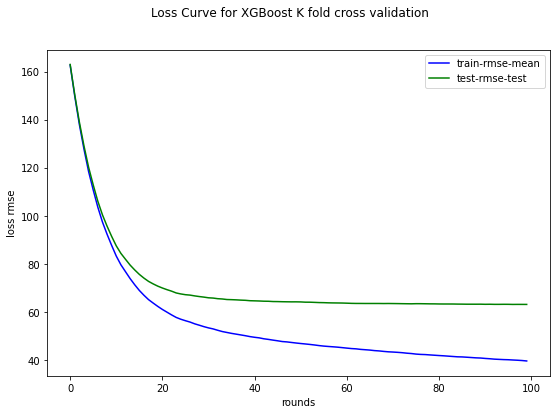

In [35]:
fig,axes=plt.subplots(1,1,figsize=(9,6))
cv_results_df=pd.DataFrame(cv_results)
axes=plt.plot(cv_results_df.index, cv_results_df['train-rmse-mean'], c='blue',label='train-rmse-mean')
axes=plt.plot(cv_results_df.index,cv_results_df['test-rmse-mean'], c='green',label='test-rmse-test')
plt.suptitle("Loss Curve for XGBoost K fold cross validation")
plt.xlabel('rounds')
plt.ylabel('loss rmse')
plt.legend(loc="upper right")

plt.show()

The model learns quickly at first and the curve levels out after ~20 rounds.

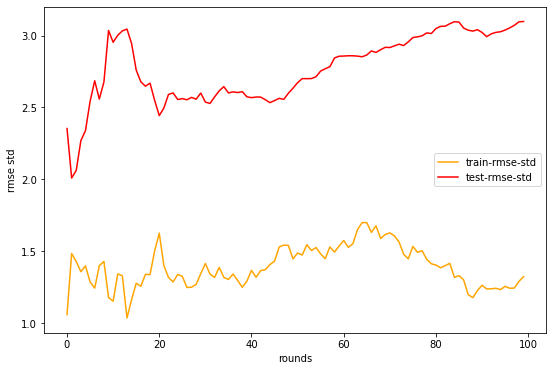

In [36]:
fig,axes=plt.subplots(1,1,figsize=(9,6))
cv_results_df=pd.DataFrame(cv_results)
axes=plt.plot(cv_results_df.index, cv_results_df['train-rmse-std'], c='orange',label='train-rmse-std')
axes=plt.plot(cv_results_df.index,cv_results_df['test-rmse-std'], c='red',label='test-rmse-std')
plt.xlabel('rounds')
plt.ylabel('rmse std')
plt.legend(loc="center right")
plt.show()

I split the rmse std plot out of the loss plot above otherwise the detail is imperceptible

In [37]:
print("RMSE Test Mean = ", (cv_results["test-rmse-mean"]).tail(1))

RMSE Test Mean =  99    63.160988
Name: test-rmse-mean, dtype: float64


In [38]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

#### Visualizing the Boosting Tree
These plots provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions.  Click or double click, on the graph to see it at a larger size if necessary, and scroll to view the whole diagram.

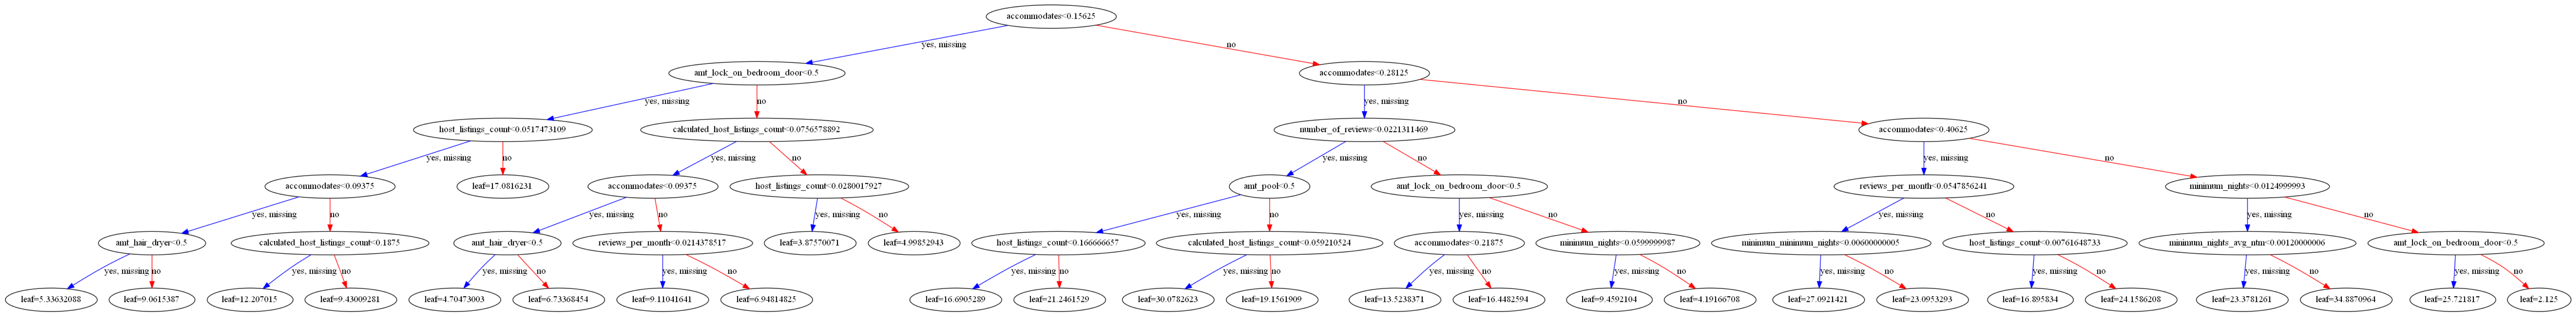

In [39]:
# Visualize the boosting tree
fig, axes = plt.subplots(figsize=(120,60))
xgb.plot_tree(xg_reg, num_trees=0,ax=axes)
plt.show()

Plot Feature Importance Histogram

This plot of feature importance can be used to eliminate weak features than have a low score.

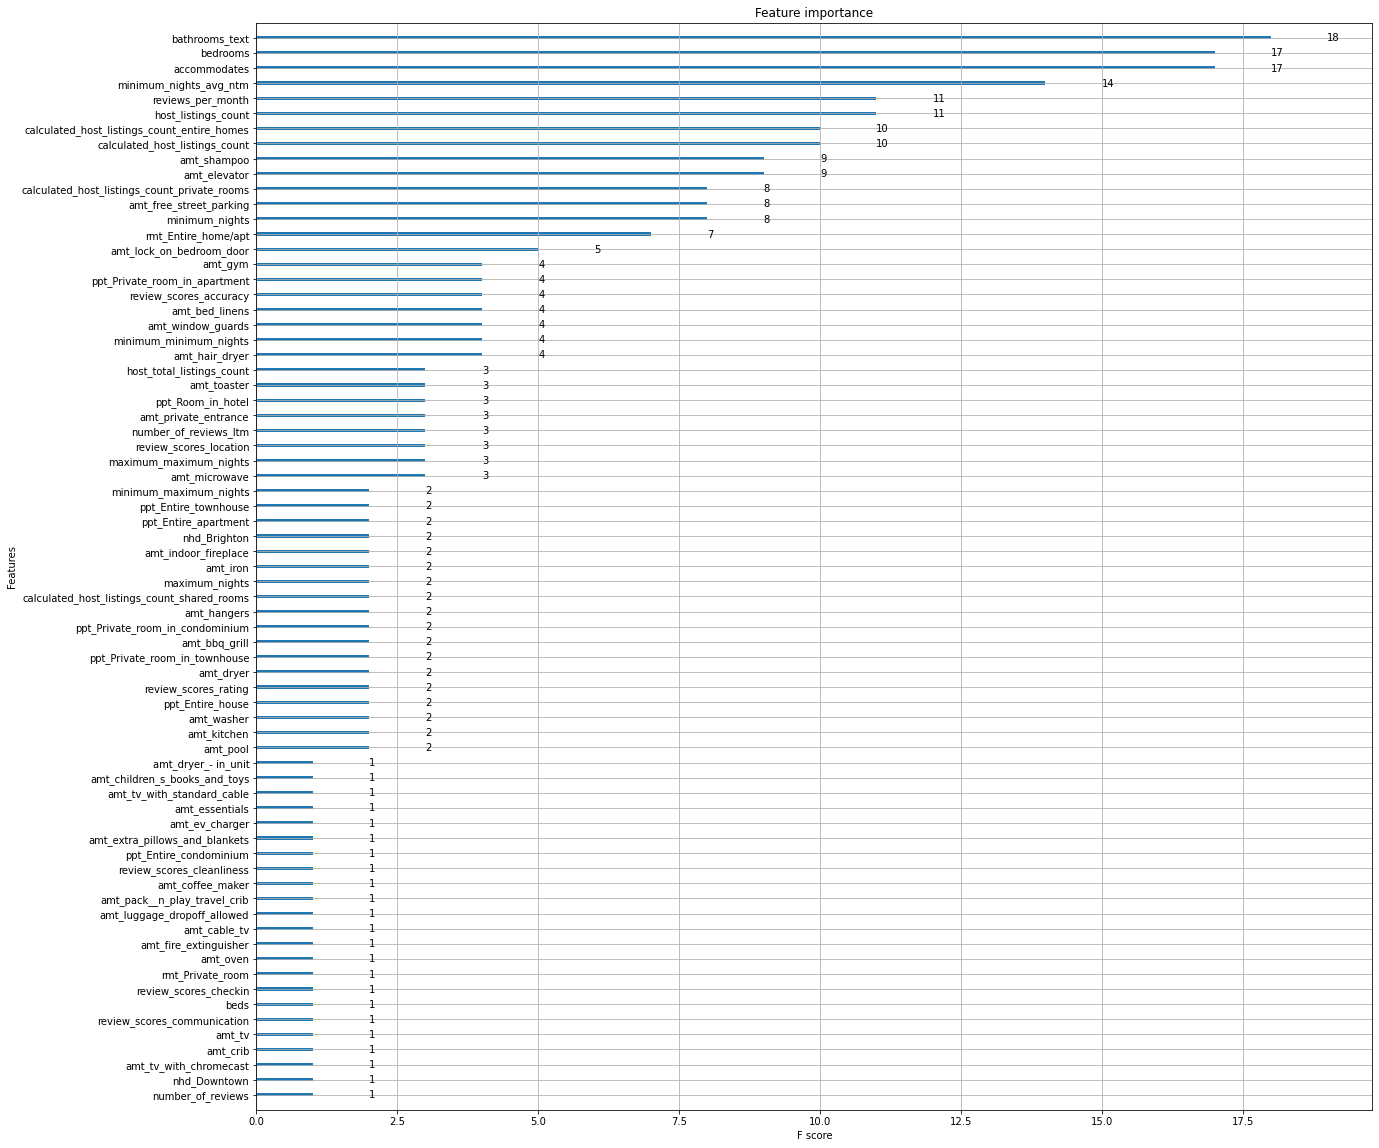

In [40]:
# Plot the XGB Feature Importance on a histogram
fig, axes = plt.subplots(figsize=(20,20))
xgb.plot_importance(xg_reg, ax=axes)
plt.show()

### Top Features

<ol>
<li>bathrooms_text</li>
<li>bedrooms</li>
<li>accomodates</li>
<li>minimum_nights_avg_ntm</li>
<li>reviews_per_month</li>
<li>host_listings_count</li>
<li>calculated_host_listings_count_entire_homes</li>
<li>calculated_host_listings_count</li>
<li>amt_shampoo</li>
<li>amt_elevator</li>
<li>calculated_host_listings_count_private_rooms</li>
<li>amt_free_street_parking</li>
<li>minimum_nights</li>
<li>rmt_Entire_home/apt</li>
</ol>

Possibly bathrooms_text gives some hint of the quality of the accomodation vis ensuite or not?

#### Create a drop list based on these feature scores

In [41]:
scores = xg_reg.get_score()
xgb_drop_list=[]

for key,val in scores.items():
    if(val<=2):
        #print(key,val)
        xgb_drop_list.append(key)

It seems supprising to find the number of beds in a listing in this list while the accommodates field it the top feature.

### Optimization Using TPOT
The following code uses TPOT to select an optimal model for our data and produces a script for us to appy it. It may take 10 to 15 minutes to run.
You will need the TPOT API http://epistasislab.github.io/tpot/ installed if you don't have than just comment out the lines below. The code analyses the data to suggest an optimal model and hyper parameters for it to run

In [42]:
from tpot import TPOTRegressor
if(False):  # Skip this as it takes some time to run
    tpot = TPOTRegressor(generations=10, population_size=50, early_stop=5, verbosity=3, \
                     periodic_checkpoint_folder='.\tpot_checkpoint' , n_jobs=-1)
    tpot.fit(X_train, y_train['log_price'])
    print(tpot.score(X_test, y_test['log_price']))
    tpot.export('tpot_airbnb.py')



In [43]:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
#tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
#features = tpot_data.drop('target', axis=1)

#training_features, testing_features, training_target, testing_target = \
#            train_test_split(features, tpot_data['target'], random_state=None)

training_features=X_train
training_target=y_train[target_name]
testing_features=X_test
testing_target=y_test[target_name]

# Average CV score on the training set was: -0.11840888516853998
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=RidgeCV()),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=3, min_samples_split=4, n_estimators=100)),
    ElasticNetCV(l1_ratio=0.5, tol=0.1)
)

exported_pipeline.fit(training_features, training_target)
y_preds = exported_pipeline.predict(testing_features)

In [44]:
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(exported_pipeline.predict(X_train))))
rmse_test=np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( exported_pipeline.predict(X_train)))


scores_df.add("Extra Trees Regressor Model",r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205


In [45]:
X_train.shape

(2176, 127)

### Random Forest Regressor

The following script was generated by TPOT I have modified it slightly so that it can use the existing data arrays. The script produces an impressive R2 score on training but falls back to a smaller score on test. The difference in rmse between train , and  test, indicates that the model is over fitted to a greater extent than the previous models.

In [46]:
#import numpy as np
#import pandas as pd
from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
#tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)

#features = tpot_data.drop('target', axis=1)

#training_features, testing_features, training_target, testing_target = \
            #train_test_split(features, tpot_data['target'], random_state=None)

training_features, testing_features, training_target, testing_target = \
    X_train,X_test,y_train['log_price'],y_test['log_price']
 
# Average CV score on the training set was: -0.12610633868471366
exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.15000000000000002,
                                          min_samples_leaf=2, min_samples_split=7, random_state=42, n_estimators=100)

exported_pipeline.fit(training_features, training_target)
y_preds = exported_pipeline.predict(testing_features)


#### Updating the Scoreboard with the Random Forest Model Score

In [47]:
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(exported_pipeline.predict(X_train))))
rmse_test=np.sqrt( mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( exported_pipeline.predict(X_train)))


scores_df.add("Random Forest Model Mk I",r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205
0,Random Forest Model Mk I,0.888756,0.632793,0.881858,0.574861,34.404870,57.977090,-23.572219


In [48]:
from tpot import TPOTRegressor

if(False):  # Skip this unless you have 20 hrs to spare
    tpot = TPOTRegressor(generations=150, population_size=100, early_stop=5, verbosity=2)
    tpot.fit(X_train, y_train[target_name])
    print(tpot.score(X_test, y_test[target_name]))
    tpot.export('tpot_airbnb1.py')

In [49]:
#import numpy as np
#import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
#from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
#tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
#features = tpot_data.drop('target', axis=1)
#training_features, testing_features, training_target, testing_target = \
#            train_test_split(features, tpot_data['target'], random_state=None)
training_features, testing_features, training_target, testing_target = \
    X_train,X_test,y_train['log_price'],y_test['log_price']

# Average CV score on the training set was: -0.11868385061903605
exported_pipeline = make_pipeline(
    make_union(
        StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.8, learning_rate=0.5, loss="quantile", max_depth=3, max_features=0.2, min_samples_leaf=20, min_samples_split=16, n_estimators=100, subsample=0.9500000000000001)),
        StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.9, learning_rate=0.5, loss="lad", max_depth=1, max_features=0.55, min_samples_leaf=4, min_samples_split=17, n_estimators=100, subsample=0.9000000000000001))
    ),
    ExtraTreesRegressor(bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
y_preds = exported_pipeline.predict(testing_features)

In [50]:
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(exported_pipeline.predict(X_train))))
rmse_test=np.sqrt( mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( exported_pipeline.predict(X_train)))


scores_df.add("GBEstimator",r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205
0,Random Forest Model Mk I,0.888756,0.632793,0.881858,0.574861,34.404870,57.977090,-23.572219
0,GBEstimator,0.969805,0.659360,0.967932,0.605620,17.924677,55.840404,-37.915727


### Random Forest Regressor

In [51]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
#tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
#features = tpot_data.drop('target', axis=1)
#training_features, testing_features, training_target, testing_target = \
#            train_test_split(features, tpot_data['target'], random_state=None)

training_features, testing_features, training_target, testing_target = X_train,X_test,y_train[target_name],y_test[target_name]

# Average CV score on the training set was: -0.1114464602811035
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, loss="huber", max_depth=4, max_features=0.4, min_samples_leaf=7, min_samples_split=16, n_estimators=100, subsample=0.2)),
    RandomForestRegressor(bootstrap=False, max_features=0.1, min_samples_leaf=1, random_state=42, min_samples_split=2, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
y_preds = exported_pipeline.predict(testing_features)


In [52]:
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(exported_pipeline.predict(X_train))))
rmse_test=np.sqrt( mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( exported_pipeline.predict(X_train)))

scores_df.add("Random Forest Model II",r2_score_train, r2_score_test, rmse_train, rmse_test,p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205
0,Random Forest Model Mk I,0.888756,0.632793,0.881858,0.574861,34.404870,57.977090,-23.572219
0,GBEstimator,0.969805,0.659360,0.967932,0.605620,17.924677,55.840404,-37.915727
0,Random Forest Model II,0.998676,0.644113,0.998594,0.587966,3.753586,57.076498,-53.322911


In [53]:
X_train.shape

(2176, 127)

### Ridge Regression

Ridge Regression uses L2 regularization.

In [54]:
def float_range(start, stop, step):
    """
    Create a range of float values
    """
    while start >= stop:
        yield float(start)
        start -= decimal.Decimal(step)

In [55]:
# Optimize Alpha for a Ridge Regression Model
from sklearn.linear_model import Ridge
ridge_result_df = pd.DataFrame(columns=['Alpha', 'mse', 'r2'])
idex=0

for n in list(float_range(-1,-7,0.1)):
    alpha_val= 10**n
    
    #print(alpha_val)
    ridgeReg=Ridge(alpha=alpha_val, normalize=False)
    ridgeReg.fit(X_train, y_train)
    y_preds= ridgeReg.predict(X_test)
    
    mse = np.mean( (y_preds[0] - y_test[target_name])**2 )

    r2 = ridgeReg.score(X_test, y_test)
    row_val=pd.DataFrame({"Alpha":alpha_val,"mse":mse,'r2':r2},index=[idex])
    idex+=1
    ridge_result_df=ridge_result_df.append(row_val)
    
#ridge_result_df

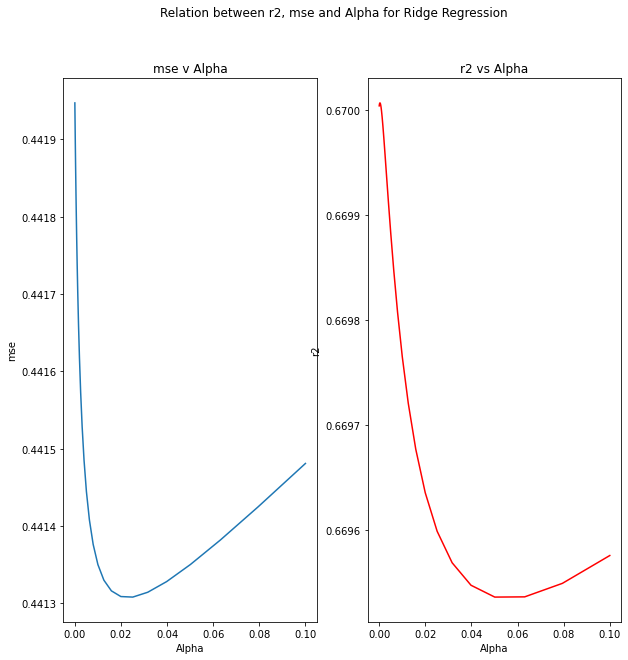

In [56]:
fig, axes = plt.subplots(1,2,figsize=(10,10))

axes[0].plot(ridge_result_df.Alpha,ridge_result_df.mse,label='mse')
axes[0].set_title('mse v Alpha')
axes[0].set_ylabel('mse')
axes[0].set_xlabel('Alpha')

axes[1].plot(ridge_result_df.Alpha,ridge_result_df.r2,label='r2',c='red')
axes[1].set_title('r2 vs Alpha')
axes[1].set_ylabel('r2')
axes[1].set_xlabel('Alpha')

fig.suptitle('Relation between r2, mse and Alpha for Ridge Regression')

plt.show()

Find the maxima and minima in the rmse R2 vs Alpha plots

In [57]:
from scipy.signal import argrelextrema

# for local maxima
maxi=argrelextrema(np.array(ridge_result_df.r2), np.greater)

print('Alpha @ r2 maxima',np.array(ridge_result_df.Alpha)[maxi[0]])

# for local minima
mini=argrelextrema(np.array(ridge_result_df.mse), np.less)

print('Alpha @ mse minima',np.array(ridge_result_df.Alpha)[mini[0]])

Alpha @ r2 maxima [0.00031623]
Alpha @ mse minima [0.02511886]


In [58]:
# Fit a Ridge Regression Model using the value of alpha indicated above

from sklearn.linear_model import Ridge
ridgeReg=Ridge(alpha=0.025,normalize=True)
ridgeReg.fit(X_train, y_train)
y_preds= ridgeReg.predict(X_test)

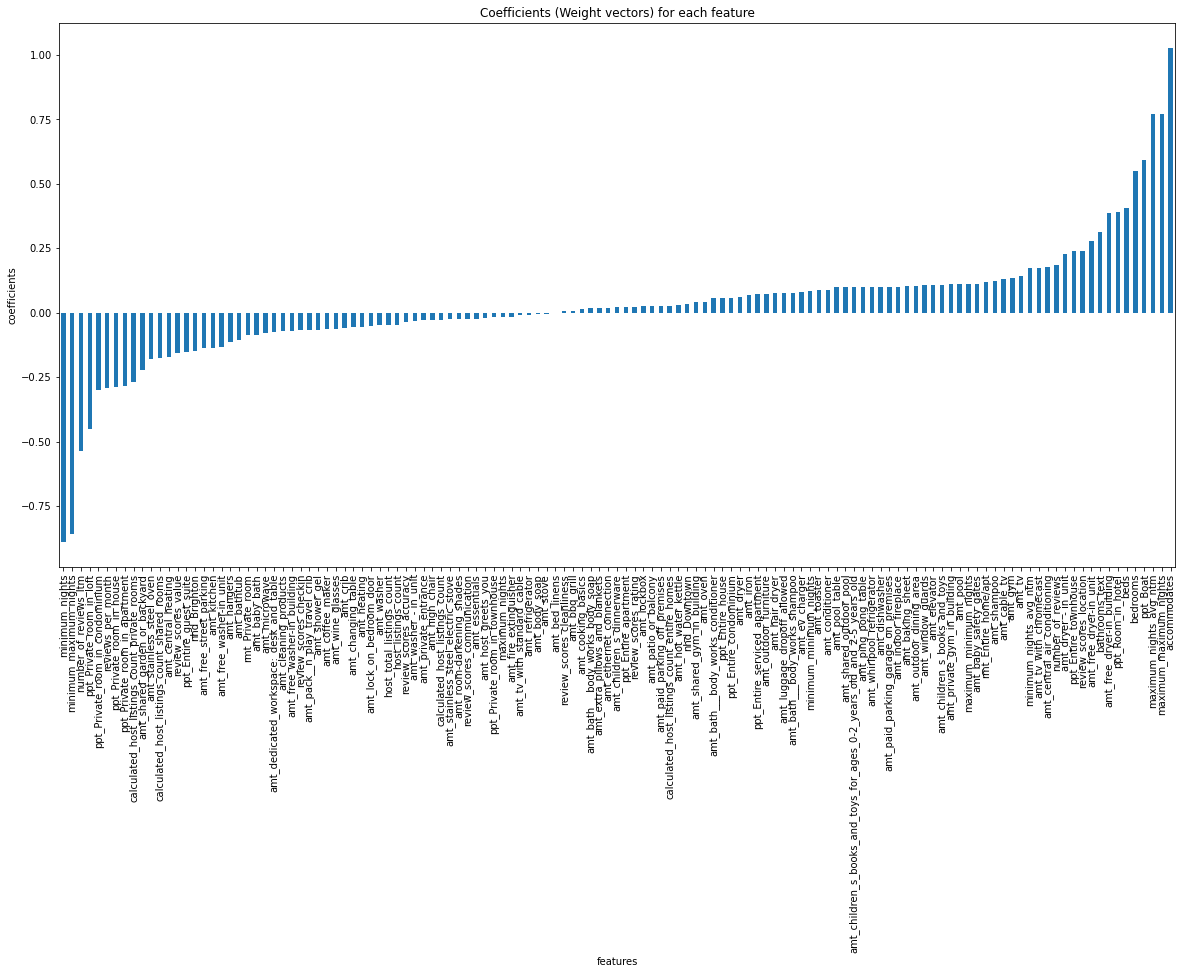

In [59]:
# Plot the magnitude of the coefficents
predictors = list( X_train.columns)

list(ridgeReg.coef_)[0]
predictors

coef = pd.Series(ridgeReg.coef_[0], predictors).sort_values()

fig,axes=plt.subplots(figsize=(20,10))

subplot = coef.plot(kind='bar',  axes=axes,title='Coefficients (Weight vectors) for each feature',
          xlabel='features' , ylabel="coefficients")

All the coeffiecents are non zero although they are very small at the centre for the plot. This is typical of L2 regularization that modifies coefficents but does not eliminate by setting to zero.

In [60]:
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(ridgeReg.predict(X_train))))
rmse_test=np.sqrt( mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( ridgeReg.predict(X_train)))

scores_df.add("Ridge Regression Model",r2_score_train, r2_score_test, rmse_train, rmse_test,p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205
0,Random Forest Model Mk I,0.888756,0.632793,0.881858,0.574861,34.404870,57.977090,-23.572219
0,GBEstimator,0.969805,0.659360,0.967932,0.605620,17.924677,55.840404,-37.915727
0,Random Forest Model II,0.998676,0.644113,0.998594,0.587966,3.753586,57.076498,-53.322911
0,Ridge Regression Model,0.572673,0.580535,0.546173,0.514358,67.431501,61.965359,5.466142


In [61]:
X_train.shape

(2176, 127)

### Lasso Model

Lasso Regression uses L2 regularization.

In [62]:
from sklearn.linear_model import Lasso
import decimal
lasso_result_df = pd.DataFrame(columns=['Alpha', 'mse', 'r2'])
idex=0

for n in list(float_range(-3,-5,0.1)):
    alpha_val= 10**n
    

    lassoReg = Lasso(alpha=alpha_val, normalize=True)

    lassoReg.fit(X_train,y_train)

    y_preds = lassoReg.predict(X_test)

    mse = np.mean((y_preds - y_test[target_name])**2)

    r2 = lassoReg.score(X_test,y_test)

    row_val=pd.DataFrame({"Alpha":alpha_val,"mse":mse,'r2':r2},index=[idex])
    
    idex+=1
    lasso_result_df=lasso_result_df.append(row_val)

#df

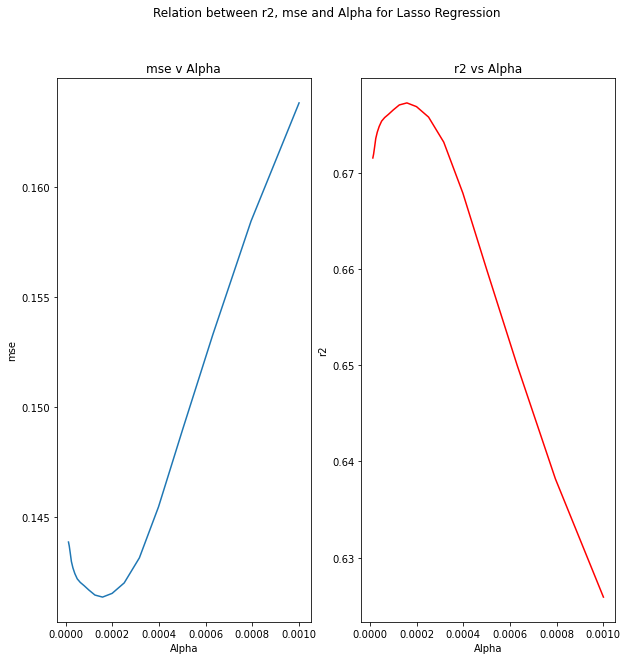

In [63]:
fig, axes = plt.subplots(1,2,figsize=(10,10))

axes[0].plot(lasso_result_df.Alpha,lasso_result_df.mse,label='mse')
axes[0].set_title('mse v Alpha')
axes[0].set_ylabel('mse')
axes[0].set_xlabel('Alpha')

axes[1].plot(lasso_result_df.Alpha,lasso_result_df.r2,label='r2',c='red')
axes[1].set_title('r2 vs Alpha')
axes[1].set_ylabel('r2')
axes[1].set_xlabel('Alpha')


fig.suptitle('Relation between r2, mse and Alpha for Lasso Regression')

plt.show()

Find minima and maxima in RMSE and R2 vs Alpha plots

In [64]:
from scipy.signal import argrelextrema

# for local maxima
maxi=argrelextrema(np.array(lasso_result_df.r2), np.greater)

print('Alpha @ r2 maxima',np.array(ridge_result_df.Alpha)[maxi[0]])

# for local minima
mini=argrelextrema(np.array(lasso_result_df.mse), np.less)

print('Alpha @ mse minima',np.array(ridge_result_df.Alpha)[mini[0]])

Alpha @ r2 maxima [0.01584893]
Alpha @ mse minima [0.01584893]


In [65]:
# Fit Lasso model
lassoReg = Lasso(alpha=0.000158, normalize=True)
lassoReg.fit(X_train,y_train)
y_preds = lassoReg.predict(X_test)

<AxesSubplot:title={'center':'Coefficients (Weight vectors)'}>

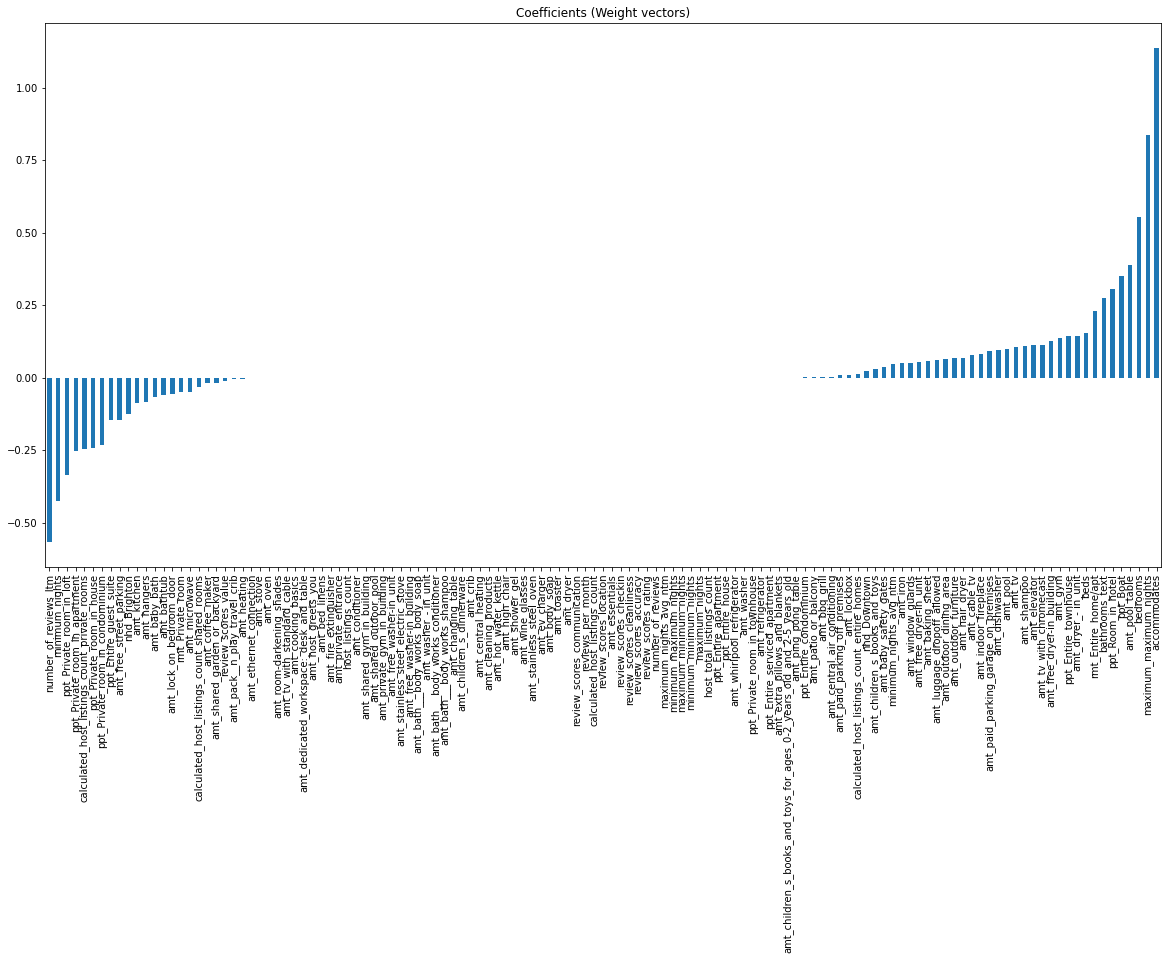

In [66]:
# Plot the magnitude of the coefficents

predictors = list( X_train.columns)

#print(lassoReg.coef_)

coef = pd.Series(lassoReg.coef_, predictors).sort_values()

fig,axes=plt.subplots(figsize=(20,10))

coef.plot(kind='bar', title='Coefficients (Weight vectors)',axes=axes)

L1 regularization employed by the lasso regresion model, reduces coefficients to zero thus effectively elmininating features from the model. The eliminated features are those in the center of the plot above, that have zero value for their coefficient.

In [67]:
# Lets build a list of features to drop based on the L1 feature regularization
coef_df=pd.DataFrame(coef)
coef_df.columns=['coef']
coef_df['feature_name']=coef.index
lasso_drop_list=coef_df[coef_df['coef']==0]
lasso_drop_list=list(lasso_drop_list['feature_name'])

In [68]:
# Here is the length of that list
len(lasso_drop_list)

61

I can use this list to eliminate weak features from the model and reduce model complexity, this should enhance performance.

In [69]:
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(lassoReg.predict(X_train))))
rmse_test=np.sqrt( mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp(lassoReg.predict(X_train)))

scores_df.add("Lasso Regression Model",r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205
0,Random Forest Model Mk I,0.888756,0.632793,0.881858,0.574861,34.404870,57.977090,-23.572219
0,GBEstimator,0.969805,0.659360,0.967932,0.605620,17.924677,55.840404,-37.915727
0,Random Forest Model II,0.998676,0.644113,0.998594,0.587966,3.753586,57.076498,-53.322911
0,Ridge Regression Model,0.572673,0.580535,0.546173,0.514358,67.431501,61.965359,5.466142
0,Lasso Regression Model,0.546941,0.579711,0.518846,0.513404,69.432050,62.026182,7.405868


### Model Scores

In [70]:
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205
0,Random Forest Model Mk I,0.888756,0.632793,0.881858,0.574861,34.404870,57.977090,-23.572219
0,GBEstimator,0.969805,0.659360,0.967932,0.605620,17.924677,55.840404,-37.915727
0,Random Forest Model II,0.998676,0.644113,0.998594,0.587966,3.753586,57.076498,-53.322911
0,Ridge Regression Model,0.572673,0.580535,0.546173,0.514358,67.431501,61.965359,5.466142
0,Lasso Regression Model,0.546941,0.579711,0.518846,0.513404,69.432050,62.026182,7.405868


In [71]:
lasso_drop_list

['amt_ethernet_connection',
 'amt_stove',
 'amt_oven',
 'amt_room-darkening_shades',
 'amt_tv_with_standard_cable',
 'amt_cooking_basics',
 'amt_dedicated_workspace:_desk_and_table',
 'amt_host_greets_you',
 'amt_bed_linens',
 'amt_fire_extinguisher',
 'amt_private_entrance',
 'host_listings_count',
 'amt_conditioner',
 'amt_shared_gym_in_building',
 'amt_shared_outdoor_pool',
 'amt_private_gym_in_building',
 'amt_free_washer-in_unit',
 'amt_stainless_steel_electric_stove',
 'amt_free_washer-in_building',
 'amt_bath___body_works_body_soap',
 'amt_washer_-\xa0in_unit',
 'amt_bath___body_works_conditioner',
 'amt_bath___body_works_shampoo',
 'amt_changing_table',
 'amt_children_s_dinnerware',
 'amt_crib',
 'amt_central_heating',
 'amt_cleaning_products',
 'amt_hot_water_kettle',
 'amt_high_chair',
 'amt_shower_gel',
 'amt_wine_glasses',
 'amt_stainless_steel_oven',
 'amt_ev_charger',
 'amt_body_soap',
 'amt_toaster',
 'amt_dryer',
 'review_scores_communication',
 'reviews_per_month',
 'c

In [72]:
# Count items in both drop lists
items_in_both =set(xgb_drop_list).intersection(lasso_drop_list)

print("xgb drop list length =", len(xgb_drop_list))
print("lasso drop list length =", len(lasso_drop_list))
print("items in both drop lists =", len(items_in_both))

xgb drop list length = 41
lasso drop list length = 61
items in both drop lists = 19


Note: Different feature selection methods have selected different features to remove. So evaluation of weak features needs to be qualified, depending on the context/model.

### Reduce the number of features
Reducing the number of features should reduce the complexity of any model and have a benefical effect on error in the model.

In [73]:
# Current Number of features
X_train.shape

(2176, 127)

In [74]:
X_train = X_train.drop(xgb_drop_list, axis=1)
X_test = X_test.drop(xgb_drop_list, axis=1)

### XGBoost Model Mk2
The XGBoost again using the reduced dataset this time

In [75]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 200)

In [76]:
xg_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse',early_stopping_rounds=10,  verbose=False) # Fit training data

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
evals_result = xg_reg.evals_result()

y_preds = xg_reg.predict(X_test) # use the model to make predictions from the test data

In [78]:
rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_preds))) # Calculate the $ price root mean squared error from predicted log(price) values
print("RMSE test $ %.2f" % (rmse_test))

#mse_train=history.history['mse'][-1]
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(xg_reg.predict(X_train))))
rmse_test=np.sqrt( mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( xg_reg.predict(X_train)))

# Get the dataset dimensions to calculate the adjusted R2
n_train=X_train.shape[0]
p_train=X_train.shape[1]
n_test=X_test.shape[0]
p_test=X_test.shape[1]


scores_df.add("XGB Model Mk II",r2_score_train, r2_score_test, rmse_train, rmse_test,p_train, n_train, p_test, n_test)
scores_df.get_score()

RMSE test $ 61.06


,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205
0,Random Forest Model Mk I,0.888756,0.632793,0.881858,0.574861,34.404870,57.977090,-23.572219
0,GBEstimator,0.969805,0.659360,0.967932,0.605620,17.924677,55.840404,-37.915727
0,Random Forest Model II,0.998676,0.644113,0.998594,0.587966,3.753586,57.076498,-53.322911
0,Ridge Regression Model,0.572673,0.580535,0.546173,0.514358,67.431501,61.965359,5.466142
0,Lasso Regression Model,0.546941,0.579711,0.518846,0.513404,69.432050,62.026182,7.405868


### Random Forest Model Mk III
Here is the random forest model with modified hyper parameters with the reduced data set.
A larger number of estimators should improve performance up until a value where this is not longer the case.

In [79]:
training_features, testing_features, training_target, testing_target = \
    X_train,X_test,y_train['log_price'],y_test['log_price']
 

exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.15, min_samples_leaf=10,
                                          max_depth=30, random_state=42,
                                          min_samples_split=7, n_estimators=250)

exported_pipeline.fit(training_features, training_target)
y_preds = exported_pipeline.predict(testing_features)

In [80]:
rmse_train=np.sqrt(mean_squared_error(np.exp(y_train), np.exp(exported_pipeline.predict(X_train))))
rmse_test=np.sqrt( mean_squared_error(np.exp(y_test), np.exp(y_preds)))

r2_score_test=r2_score(np.exp(y_test), np.exp(y_preds))
r2_score_train=r2_score(np.exp(y_train), np.exp( exported_pipeline.predict(X_train)))


scores_df.add("Random Forest Model Mk III", r2_score_train, r2_score_test, rmse_train, rmse_test, p_train, n_train, p_test, n_test)
scores_df.get_score()

,Model,R2_Score_train,R2_Score_test,R2_Score_train_Adj,R2_Score_test_Adj,RMSE_train,RMSE_test,RMSE_diff
0,OLS Model,0.576395,0.563577,0.550126,0.494725,67.137204,63.205477,3.931727
0,TF Model 25,0.694743,0.595261,0.675814,0.531407,56.992185,60.867952,-3.875766
0,TF Model 52,0.925048,0.557388,0.920400,0.487560,28.240676,63.652049,-35.411373
0,XGB Model,0.634022,0.600564,0.611327,0.537547,62.403691,60.467865,1.935825
0,Extra Trees Regressor Model,0.922500,0.639178,0.917694,0.582253,28.716621,57.470827,-28.754205
0,Random Forest Model Mk I,0.888756,0.632793,0.881858,0.574861,34.404870,57.977090,-23.572219
0,GBEstimator,0.969805,0.659360,0.967932,0.605620,17.924677,55.840404,-37.915727
0,Random Forest Model II,0.998676,0.644113,0.998594,0.587966,3.753586,57.076498,-53.322911
0,Ridge Regression Model,0.572673,0.580535,0.546173,0.514358,67.431501,61.965359,5.466142
0,Lasso Regression Model,0.546941,0.579711,0.518846,0.513404,69.432050,62.026182,7.405868


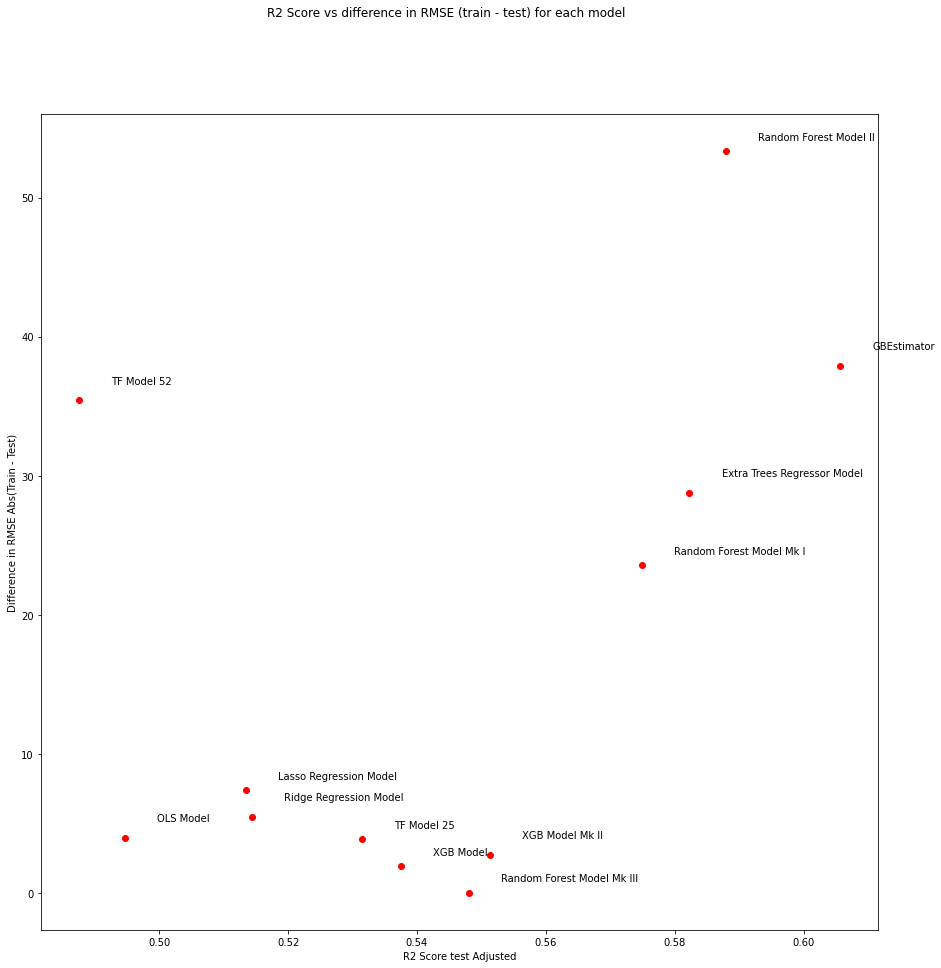

In [81]:
# Plot RMSE Diff vs R2 Score Adjusted
fig, axes = plt.subplots(1,1, figsize=(15,15))
scores=  scores_df.get_score()
axes.scatter(scores['R2_Score_test_Adj'], np.abs(scores['RMSE_diff']), color='r')
axes.set_xlabel('R2 Score test Adjusted')
axes.set_ylabel('Difference in RMSE Abs(Train - Test)')

odd=0
cnt=0
for index, row in scores.iterrows():
    cnt+=1
    
    if(cnt%2 == 0):
        odd=0.0
    else:
        odd=0.4
    # Apply model name labels
    axes.text(x= row['R2_Score_test_Adj'] + 0.005, y= np.abs( row['RMSE_diff']) + 0.8 + odd,s= row['Model'])
fig.suptitle('R2 Score vs difference in RMSE (train - test) for each model')
    
plt.show()

### Summary
I have created a number of models all with a R2 ~0.5 
The ordinary least squares (OLS) Model gives us a base line to work from. Using the adjusted R2 score the score is just less than 0.5 so 50% of the variance in the dependent varriable (log price) is predictable from the variance in the independent variables (features)

Using TPOT I have generated the four models Random ForestII, GBEstimator, Extra Trees Regressor Model, Random Forest Model MkI (See top right of plot). Theses are all models with high R2 score on training data. They have significantly lower R2 scores on test data so must be considered to be overfitted. So despite having high R2 test Adjusted R2 scores these must be considered relatively poor models. Note that the Random forest II model has a R2 Score train of 0.998 is over fitted but still achieves the lowest RMSE test value.

The tensorflow model TF Model 25 performs well. However the TF Model52 which uses early stopping to try to prevent overfitting fails because the slope on the loss curve is steep enough that it keeps going to the 52th epoch. The R2 Test Adjusted is lower than the OLS as well, so early stopping did not work to improve performance in this case.

Ridge and Lasso Regression models the performance is comparible with the 'OLS Model' and has a higher R2 score.
The XGboost model 'XGB Model' performs better than 'TF Model 25' and improves when the number of features are reduced.

I have chosen the Random Forest Model MkIII as the winner here. The model numerically has low difference in RMSE train and RMSE test so little overfitting, a relatively high R2 Score relative to the other models on this side of plot. I am disqualifying the models with higher R2 Scores due to them being  over fitted.  

Note I would not have tried the Random Forest model out if it had not been selected in the TPOT analysis I then changed the hyper parameters to get this result.  The models in this part of the plot are close together so estimation of errors would be useful before making comparisons. 

